<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 9 - Multilayer Perceptron Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Malawi Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
&nbsp;&nbsp;&nbsp;[Explanation and Theory](#introduction-theory)  
&nbsp;&nbsp;&nbsp;[Considerations](#introduction-considerations)  
[Data Setup](#setup)  
[Scikit-Learn Multilayer Perceptron Classifier](#sklearn-mlp)  
&nbsp;&nbsp;&nbsp;[Include All Features](#all-feats)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Multilayer Perceptron Classifier Introduction <a class="anchor" id="introduction"></a>

Multilayer perceptron (MLP) classifiers are the most basic example of the popular _deep learning_ framework that has dominated machine learning in recent years. MLPs are feed-forward neural networks that learn to re-express, or re-represent the input data as it passes through the layers of the network before performing a standard classification algorithm, often logistic regression, in the final layer. The rough idea is that each layer of the network corresponds to a more abstract representation of the signal while filtering out the noise. The classification layer then trains on these abstract representations rather than the raw data. Ideally, neural networks essentially do feature engineering for us. In practice, they can be computationally expensive and tricky to train. But for some applications, especially in image and language processing, more advanced neural networks outperform everything else.  

## Explanation and Theory <a class="anchor" id="introduction-theory"></a>

**Assumptions and properties.** From a high level, MLPs (also called feed-forward neural networks) function in a straightforward way. An input vector moves from one layer to the next via matrix multiplication. In between layers a nonlinear function is applied to the output of the previous layer, impacting the result of the next matrix multiplication. This back and forth of matrix multiplication and nonlinear activation continues until the output of the network is compared to the ground truth using a standard loss function. The resulting loss is then used with gradient descent to update the numbers in the matrices of the network. The cycle continues until training is complete (loss is minimized or some stopping condition is met).

__PICTURE HERE__

While parts of the process shold seem familiar, we have introduced some new terms worth exploring: layers and activations.

_Layers._ In the graphical representation of a MLP, the layers consist of collections of nodes that aren't connected to each other, but are connected to the next (and possibly previous) layer. The connections, represented by lines from one layer to the next, actually correspond to "weights," elements of a matrix that encodes the transform from one layer to the next. The matrix that moves one layer to the next has a number of columns equal to the number of nodes in the current layer, and a number of rows equal to the number of nodes in the next layer. The task of training a MLP is to learn the correct weights between layers.

The input layer of an MLP must be fully vectorized. In fact, the first layer of a MLP network has as many nodes as there are dimensions in the data. For example, if we're using the full feature set of the processed Malawi data, the first layer of our MLP will have a size of 484.

The final layer of a MLP classification network should have a size equal to the number of classes for a multi-class classification problem. For binary classification, it suffices to have a single output node. In the case of the povery data this means the last layer has a size of 1.

The layers in between the first and last layers, called _hidden layers_, can be of any size. It's important to note that __there should be at least one hidden layer__ or else the network may not be able to learn a useful representation of the data (unless the data is perfectly linearly seperable). There is no rigorous prescription for how many nodes a hidden layer should have, but too many nodes – e.g., more than twice the number of input nodes – will overfit the data. Too few nodes – e.g., less than the geometric mean of the input and output layers, 22 for the Malawi data – will fail to capture the complexity of data and underfit. Note also that there can be more than one hidden layer. The more hidden layers there are, the _deeper_ the network.

_Activations_. The real power of neural networks comes from their use of nonlinear activation functions between layers. After a set of weights is moves values from one layer to another, but before the next set of weights are applied, a nonlinear thresholding function is used to zero-out some values. If a value is above the threshold, the subsequent neuron will be "activated," othrwise the value will be zeroed-out. This is why we call these activation functions. The most common choice of nonlinear activation is the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks), written as $f(x) = \max(0,x)$. The ReLU function just returns the input is it's positive, and returns a zero otherwise. Adding in this simple nonlinearity enables the MLP to model arbitrarily complicted functions. This is good because at the end of the day, classification algorithms can be viewed simply as functions that map inputs to classes.

**Algorithm and Training.** As mentioned above, the output of a _forward pass_ through a MLP is processed through a loss function in the usual way. For example, in binary classification the final node of a MLP may be passed through a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) function to "squash" the result into the range $(0,1)$, representing the probability of class $0$ or $1$. The cross-entropy loss function may then be computed, and some scalar loss value generated. A central difficulty concerning training neural network models is the following. How should the loss in the last layer change the weights in the first layer? Or, how do we use the loss to update the weights throughout the _entire_ netowork? In other words, how do we perform gradient descent in a MLP?

This is where backpropagation comes in. Ultimately, backpropagation is just a way of recursively applying the chain rule from calculus that enables gradient descent optimization in neural networks. Before backpropagation, training neural networks was nearly intractable. It is beyond the scope of these notebooks to get into the specifics of how backpropagation works, but for the interested reader familiar with basic calculus, [this tutorial](http://cs231n.github.io/optimization-2/) from a Stanford course on deep learning is a great place to start. In scikit-learn, we need only call on the trusty `.fit()` method to implement the _backwards pass_ (backpropagation) through the network.

Beyond this, there are only a couple more issues that impact training a MLP. First, there is a _learning rate_ hyperparamter. This is the same paramter that controls the size of the step in any gradient descent based algorithm. It matters here as well. Next, a vocabulary note. Neural netowrks are typically trained using "batches" of many data points at once. This is because the matrix formulation of neural netowrks allows the input vector $\mathbf{x}$ to be expanded into a _matrix_ of inputs, $\mathbf{X}$. So you will often see a parameter called "batch size." Unless you're working with a very large dataset, the default batch size is probably ok. Finally, in the context of batches, you may also see the word "epoch." An epoch is just a single pass thrhough all the data. So if I have 100 training points and a batch size of 10, a single epoch will occur every 10 batches.

## Considerations <a class="anchor" id="introduction-considerations"></a>

Neural networks have many, many parameters, and can be computationally expensive to train and hard to debug. Furthermore, they are _not neccessarily_ the best choice for every dataset! Sometimes a simple logisitc regression will suffice.

We will be using scikit learn's built in neural network module in this notebook. In the next notebook, we will introduce a more commomly used deep learning package, `keras`.

# Data setup <a class="anchor" id="setup"></a>

First, load in the standard libraries and inspect the training data. 

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import MWI_BASIC_FEATURES

ALGORITHM_NAME = 'mlp'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 484 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,hld_dwelloccu__Employer provides,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
hid,,,,,,,,,,,,,,,,,,,,,
304044580160,5,3,0.0,1.0,3,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
205205820123,3,2,1.0,3.0,1,1,1,2,1,0,...,1,0,0,0,0,0,0,0,0,0
102016880095,6,5,0.0,2.0,3,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
315356330210,3,3,3.0,3.0,1,1,1,3,1,0,...,1,1,0,0,0,0,0,0,1,1
313061660067,2,1,0.0,2.0,0,1,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0


# Scikit-Learn Multilayer Perceptron Model <a class="anchor" id="sklearn-mlp"></a>

In [3]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


CPU times: user 30.5 s, sys: 5min 11s, total: 5min 41s
Wall time: 37 s
CPU times: user 76.5 ms, sys: 714 ms, total: 791 ms
Wall time: 82 ms
In-sample score: 77.30%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


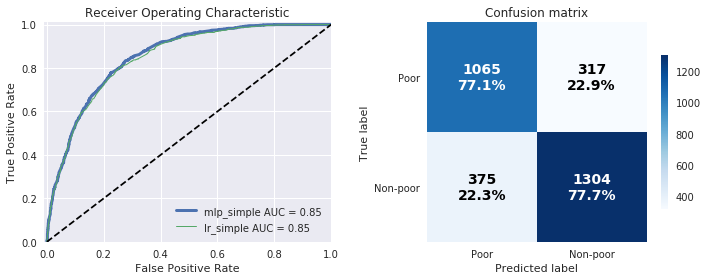

,mlp_simple,lr_simple
accuracy,0.77393,0.766743
recall,0.770622,0.738784
precision,0.739583,0.743086
f1,0.754784,0.740929
cross_entropy,0.46695,0.478969
roc_auc,0.853886,0.847856
cohen_kappa,0.545251,0.528811


Actual poverty rate: 54.11% 
Predicted poverty rate: 60.07% 


In [4]:
from sklearn.neural_network import MLPClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = MLPClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)

## MLP with all features <a class="anchor" id="all-feats"></a>

Now let's try using the full feature set

CPU times: user 4min 10s, sys: 45min 16s, total: 49min 26s
Wall time: 14min 49s
CPU times: user 195 ms, sys: 1 s, total: 1.2 s
Wall time: 494 ms
In-sample score: 100.00%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


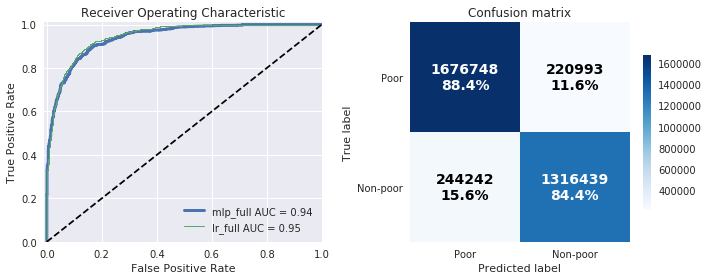

,mlp_full,lr_full
accuracy,0.865478,0.873897
recall,0.88355,0.869754
precision,0.872856,0.853693
f1,0.87817,0.861649
cross_entropy,0.641859,0.288223
roc_auc,0.94137,0.948658
cohen_kappa,0.73721,0.745821


Actual poverty rate: 54.11% 
Predicted poverty rate: 54.27% 


In [5]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = MLPClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)

The default model gives us decent results on the full dataset, but the high in-sample score is a good indication of over-fitting.

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>



Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] alpha=1.0, hidden_layer_sizes=(512,) ............................
[CV]  alpha=1.0, hidden_layer_sizes=(512,), score=0.8641410842586544, total=  54.3s
[CV] alpha=1.0, hidden_layer_sizes=(512,) ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.4s remaining:    0.0s


[CV]  alpha=1.0, hidden_layer_sizes=(512,), score=0.8778177066318197, total=  57.2s
[CV] alpha=1.0, hidden_layer_sizes=(512,) ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV]  alpha=1.0, hidden_layer_sizes=(512,), score=0.8826797385620915, total=  41.9s
[CV] alpha=1.0, hidden_layer_sizes=(1024,) ...........................
[CV]  alpha=1.0, hidden_layer_sizes=(1024,), score=0.8674069235793599, total= 1.1min
[CV] alpha=1.0, hidden_layer_sizes=(1024,) ...........................
[CV]  alpha=1.0, hidden_layer_sizes=(1024,), score=0.8660568441685723, total= 1.0min
[CV] alpha=1.0, hidden_layer_sizes=(1024,) ...........................
[CV]  alpha=1.0, hidden_layer_sizes=(1024,), score=0.8800653594771242, total= 1.4min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.1min finished


CPU times: user 7min 35s, sys: 54min 47s, total: 1h 2min 22s
Wall time: 6min 46s
CPU times: user 1.13 s, sys: 6.63 s, total: 7.76 s
Wall time: 897 ms
In-sample score: 90.35%
Best model parameters: {'alpha': 1.0, 'hidden_layer_sizes': (512,)}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


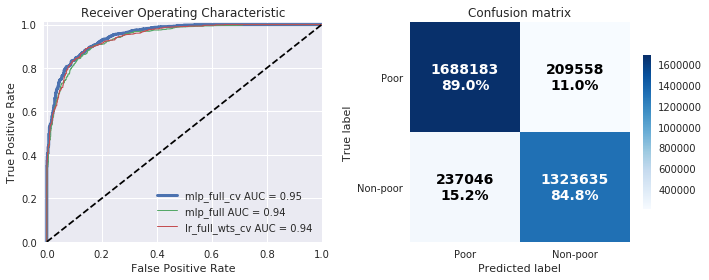

,mlp_full_cv,mlp_full,lr_full_wts_cv
accuracy,0.870865,0.865478,0.873458
recall,0.889575,0.88355,0.891581
precision,0.876874,0.872856,0.87947
f1,0.883179,0.87817,0.885484
cross_entropy,0.279533,0.641859,0.300498
roc_auc,0.950956,0.94137,0.944474
cohen_kappa,0.753925,0.73721,0.734446


Actual poverty rate: 54.11% 
Predicted poverty rate: 55.13% 


In [6]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build the model
estimator = MLPClassifier()
parameters = {'hidden_layer_sizes': [(512,), (1024,)],
              'alpha': [1.0]
             }
model = GridSearchCV(estimator, parameters, verbose=3, cv=3)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['mlp_full', 
                                                    'lr_full_wts_cv'],
                                    store_model=True,
                                    model_name='full_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=X_test.columns.values)
best_model = model.best_estimator_

This gives us a noticeable boost in performance, with a better recall and much lower cross-entropy than the default model. 

# Multilayer Perceptron Classifier Malawi Summary <a class="anchor" id="summary"></a>



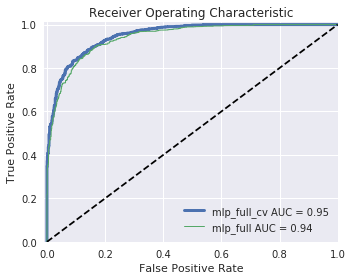

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
mlp_full_cv,0.870865,0.889575,0.876874,0.883179,0.279533,0.950956,0.753925,0.0102651
mlp_full,0.865478,0.88355,0.872856,0.87817,0.641859,0.94137,0.73721,0.00165313


In [7]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)